In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Optional
import os
import pickle

import pandas as pd
import numpy as np

import torch
from pytorch_lightning import LightningDataModule
from pytorch_lightning.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data.dataset import T_co

C:\Users\User\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\User\anaconda3\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Users\User\anaconda3\lib\site-packages\numpy\.libs\libopenblas.gk7gx5keq4f6uyo3p26ulgbqyhgqo7j4.gfortran-win_amd64.dll
C:\Users\User\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
import numpy as np
import pandas as pd

from tqdm import tqdm

import torch

import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset, random_split

from src import Conv1dAutoEncoder, LSTMAutoEncoderEmbed, TransactionDataModuleNewData, TransactionDatasetNewData

In [7]:
dataset_normal = TransactionDatasetNewData('data/normal/')
dataset_anomaly = TransactionDatasetNewData('data/anomaly/')

In [8]:
len(dataset_normal), len(dataset_anomaly)

(351060, 99870)

In [ ]:
351060+99870

In [6]:
model = Conv1dAutoEncoder.load_from_checkpoint(
    'lightning_logs/cae/version_0/checkpoints/epoch=19-step=87780.ckpt',
    in_channels=1,
    n_latent_features=8
)

In [9]:
model = LSTMAutoEncoderEmbed(17, 4)
checkpoint = torch.load('.\\lightning_logs_new\\lstm\\version_4\\checkpoints\\epoch=19-step=87780.ckpt')
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [37]:
from torchsummary import summary

In [58]:
summary(model, (8,40,1))

RuntimeError: Sizes of tensors must match except in dimension 3. Expected size 39 but got size 1 for tensor number 1 in the list.

In [10]:
with torch.no_grad():
    info_normal = model.predict_step(dataset_normal[100].unsqueeze(0))
    info_anomaly = model.predict_step(dataset_anomaly[431].unsqueeze(0))

In [11]:
info_normal['loss'].item(), info_anomaly['loss']

(0.07761400192975998, tensor(0.2436))

In [13]:
info_normal['latent']

tensor([[ 0.5385,  0.2488, -0.2608,  0.4762]])

In [14]:
losses_normal = np.zeros(len(dataset_normal), dtype=np.float16)
losses_anomaly = np.zeros(len(dataset_anomaly), dtype=np.float16)

features_normal = np.zeros((len(dataset_normal), 4), dtype=np.float16)
features_anomaly = np.zeros((len(dataset_anomaly), 4), dtype=np.float16)

with torch.no_grad():
    for i, normal_sample in tqdm(enumerate(dataset_normal), total=len(dataset_normal)):
        model_sample = model.predict_step(normal_sample.unsqueeze(0))
        losses_normal[i] = model_sample['loss'].item()
        features_normal[i] = model_sample['latent']

    for i, anomaly_sample in tqdm(enumerate(dataset_anomaly), total=len(dataset_anomaly)):
        model_sample = model.predict_step(anomaly_sample.unsqueeze(0))
        losses_anomaly[i] = model_sample['loss'].item()
        features_anomaly[i] = model_sample['latent']

100%|████████████████████████████████████████████████████████████████████████| 351060/351060 [1:51:39<00:00, 52.40it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'data/normal/351060.csv'

In [17]:
with torch.no_grad():
    for i, anomaly_sample in tqdm(enumerate(dataset_anomaly), total=len(dataset_anomaly)):
        model_sample = model.predict_step(anomaly_sample.unsqueeze(0))
        losses_anomaly[i] = model_sample['loss'].item()
        features_anomaly[i] = model_sample['latent']

100%|███████████████████████████████████████████████████████████████████████████| 99870/99870 [10:37<00:00, 156.73it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'data/anomaly/99870.csv'

In [65]:
with torch.no_grad():
    for i, anomaly_sample in tqdm(enumerate(dataset_anomaly), total=len(dataset_anomaly)):
        model_sample = model.predict_step(anomaly_sample.unsqueeze(0))
        losses_anomaly[i] = model_sample['loss'].item()
        features_anomaly[i] = model_sample['latent'].squeeze().mean(1).numpy()

100%|██████████| 99870/99870 [14:37<00:00, 113.77it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'data/new_data/anomaly/99870.csv'

In [22]:
print(f'mean {losses_normal.mean()}')
print(f'min {losses_normal.min()}')
print(f'max {losses_normal.max()}')

mean 0.11004638671875
min 0.0035762786865234375
max 8.90625


In [23]:
print(f'mean {losses_anomaly.mean()}')
print(f'min {losses_anomaly.min()}')
print(f'max {losses_anomaly.max()}')

mean 0.289306640625
min 0.00669097900390625
max 10.8828125


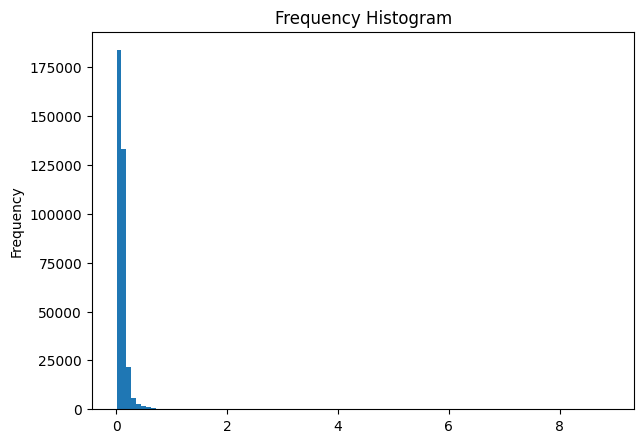

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Histogram on x
x = losses_normal
plt.hist(x, bins=100)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Histogram on x
x = losses_anomaly
plt.hist(x, bins=100)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

In [68]:
losses_normal.max()

8.58

In [69]:
losses_anomaly.max()

10.53

In [70]:
losses_anomaly.min()

0.1338

In [71]:
losses_normal.min()

0.1259